# Chatbot/LLM with tools = Agent 

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()


from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list,add_messages]


In [2]:
from langchain_groq import  ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")

In [3]:
from langchain_tavily import TavilySearch

searchTool=TavilySearch(max_results=2)
searchTool.invoke("What is LangGraph?")

{'query': 'What is LangGraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is LangGraph? - IBM',
   'url': 'https://www.ibm.com/think/topics/langgraph',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling 

In [4]:
## custom function  -
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): First number.
        b (int): Second number.

    Returns:
        int: Product of a and b. (output int)
    """
    return a*b

In [5]:
tools=[searchTool,multiply]

In [6]:
llm_with_tool=llm.bind_tools(tools)

In [7]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x116b382f0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x116b38ec0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to 

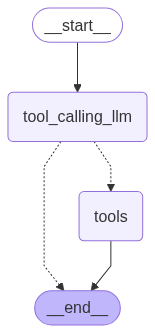

In [8]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
response=graph.invoke({"messages":"What are the recent ai news"})

In [10]:
#response
response['messages'][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.lightreading.com/ai-machine-learning/bt-and-vodafone-tech-bosses-troubled-by-dark-side-of-ai", "title": "BT and Vodafone tech bosses troubled by dark side of AI - Light Reading", "score": 0.6501347, "published_date": "Fri, 20 Jun 2025 11:21:04 GMT", "content": "AI & Machine Learning T-Mobile taps OpenAI to reduce customer churn 19/09/2024\\n\\n### Recommended for you\\n\\nAI & Machine Learning Image 22 sponsored Enterprise Networks Evolve From Basic Connectivity to Dynamic Experiences 29/04/2025\\n\\nAI & Machine Learning Orange is working on an AI network \'brain\' to run 5G 18/03/2025\\n\\nAI & Machine Learning MWC visitor numbers are up again, but the industry is decaying 07/03/2025 [...] See more from Iain Morris\\n\\nSubscribe and receive the latest news from the industry.\\n\\nJoin 62,000+ members. Yes it\'s completely free.\\n\\nSign me up\\n\\nYou May Also Li

In [11]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What are the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (hj8nkapjg)
 Call ID: hj8nkapjg
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.lightreading.com/ai-machine-learning/bt-and-vodafone-tech-bosses-troubled-by-dark-side-of-ai", "title": "BT and Vodafone tech bosses troubled by dark side of AI - Light Reading", "score": 0.6501347, "published_date": "Fri, 20 Jun 2025 11:21:04 GMT", "content": "AI & Machine Learning T-Mobile taps OpenAI to reduce customer churn 19/09/2024\n\n### Recommended for you\n\nAI & Machine Learning Image 22 sponsored Enterprise Network

In [12]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (f9bc8gz5y)
 Call ID: f9bc8gz5y
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [13]:
response=graph.invoke({"messages":"Give me the recent ai news and also multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and also multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (nsk1t032k)
 Call ID: nsk1t032k
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
  multiply (4q7wvd1rw)
 Call ID: 4q7wvd1rw
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://analyticsindiamag.com/ai-news-updates/", "title": "Artificial Intelligence News - Latest AI News, Updates and Launches", "content": "Latest in AI News · HAL Secures SSLV Technology Transfer Contract, Bids ₹511 Crore · Ola's Krutrim Acquires BharatSah'AI'yak to Scale AI Solutions for Public", "score": 0.77446437, "raw_content": null}, {"url": "https://ma